#Zadanie 4 (7 pkt)
Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Implementacja funkcji entropii - **0.5 pkt**
* Implementacja funkcji entropii zbioru - **0.5 pkt**
* Implementacja funkcji information gain - **0.5 pkt**
* Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - **4 pkt**
* Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - **1.5 pkt**

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
from typing import Tuple, Optional, List
import matplotlib.pyplot as plt
from posixpath import split


iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123) # zostawić te wartości podziału


#Notatki
<!-- liczymy aż wszystkie kwiatki w nodzie są z jednego gatunku, albo głebokość jest wystarczająca


Wykres dla róznago podziału zbioru accuracy w stosunku do głembokości
(dla podziału 20 80 jeden wykres, potem dla 15 85 drugi itd., następnie przedstawić te wykresy na jednym razem)

Dla większych głębokości wachania są zazwyczanj nieco większe (?) -->

#Implementacja

In [2]:
def entropy_func(class_count: int, num_samples: int) -> float:
    return class_count / num_samples * np.log(class_count / num_samples)


def get_available_classes(group_classes: np.ndarray) -> np.ndarray:
    return np.unique(group_classes)


class Group:
    def __init__(self, group_classes: np.ndarray) -> None:
        self.group_classes = group_classes
        self.entropy = self.group_entropy()

    def __len__(self) -> int:
        return self.group_classes.size

    def group_entropy(self) -> np.float32:
        group_entropy = 0
        for class_type in get_available_classes(self.group_classes):
            group_entropy += entropy_func(
                np.count_nonzero(self.group_classes == class_type),
                len(self.group_classes),
            )
        return -group_entropy


class Node:
    # można by było dodać gettery i settery
    def __init__(
        self,
        split_feature: int,
        split_val: float,
        depth: Optional[int] = None,
        child_node_a=None,
        child_node_b=None,
        val: Optional[int] = None,
    ) -> None:
        self.split_feature = split_feature
        self.split_val = split_val
        self.depth = depth
        self.child_node_a = child_node_a
        self.child_node_b = child_node_b
        self.val = val

    def predict(self, data: List[float]) -> int:
        if self.val is not None:
            return self.val
        if data[self.split_feature] <= self.split_val:
            return self.child_node_a.predict(data)
        return self.child_node_b.predict(data)


class DecisionTreeClassifier:
    def __init__(self, max_depth) -> None:
        self.depth = 0
        self.max_depth = max_depth
        self.tree = []

    @staticmethod
    def get_split_entropy(group_a: Group, group_b: Group) -> float:
        return group_a.entropy * (
            len(group_a) / (len(group_a) + len(group_b))
        ) + group_b.entropy * (len(group_b) / (len(group_a) + len(group_b)))

    def get_information_gain(
        self, parent_group: Group, child_group_a: Group, child_group_b: Group
    ) -> float:
        return parent_group.entropy - self.get_split_entropy(
            child_group_a, child_group_b
        )

    def get_best_feature_split(
        self, feature_values: np.ndarray, classes: np.ndarray
    ) -> Tuple[float]:
        nodes_dict = {}
        for feature_value in np.unique(feature_values):
            split_groups = self._split_classes_based_on_feature(
                feature_value, feature_values, classes
            )
            information_gain = self.get_information_gain(
                Group(np.array(classes)),
                Group(np.array(split_groups[0])),
                Group(np.array(split_groups[1])),
            )
            nodes_dict[information_gain] = feature_value
        return nodes_dict[max(nodes_dict.keys())], max(nodes_dict.keys())

    def get_best_split(self, data: np.ndarray, classes: np.ndarray) -> Node:
        nodes_dict = {}
        for feature in range(len(data[0])):
            feature_value, information_gain = self.get_best_feature_split(
                [element[feature] for element in data], classes
            )
            nodes_dict[information_gain] = Node(feature, feature_value)
        return nodes_dict[max(nodes_dict.keys())]

    def build_tree(self, data: np.ndarray, classes: np.ndarray, depth=0) -> Node:
        if len(np.unique(classes)) == 1:
            self.tree.append(Node(None, None, depth, val=classes[0]))
            return self.tree[-1]
        if depth == self.max_depth:
            self.tree.append(
                Node(None, None, depth, val=max(set(classes), key=classes.count))
            )
            return self.tree[-1]
        best_node = self.get_best_split(data, classes)
        best_node.depth = depth
        self.tree.append(best_node)
        split_group = self._split_features_into_groups(
            best_node.split_feature, best_node.split_val, data, classes
        )
        best_node.child_node_a = self.build_tree(
            split_group[2], split_group[0], depth + 1
        )
        best_node.child_node_b = self.build_tree(
            split_group[3], split_group[1], depth + 1
        )
        return best_node

    def predict(self, data: np.ndarray) -> int:
        return self.tree[0].predict(data)

    def _split_classes_based_on_feature(
        self,
        feature_split_value: float,
        feature_values: np.ndarray,
        classes: np.ndarray,
    ) -> List[np.ndarray]:
        below_split_classes = []
        above_split_classes = []
        for feature_test_value, class_test_value in zip(feature_values, classes):
            if feature_test_value <= feature_split_value:
                below_split_classes.append(class_test_value)
            else:
                above_split_classes.append(class_test_value)
        return [below_split_classes, above_split_classes]

    def _split_features_into_groups(
        self,
        feature: int,
        feature_split_value: float,
        feature_values: np.ndarray,
        classes: np.ndarray,
    ) -> List[np.ndarray]:
        lower_group_classes, lower_group_features = [], []
        higher_group_features, higher_group_classes = [], []
        for feature_test_value, class_test_value in zip(feature_values, classes):
            if feature_test_value[feature] <= feature_split_value:
                lower_group_classes.append(class_test_value)
                lower_group_features.append(feature_test_value)
            else:
                higher_group_classes.append(class_test_value)
                higher_group_features.append(feature_test_value)
        return [
            lower_group_classes,
            higher_group_classes,
            lower_group_features,
            higher_group_features,
        ]

#Test z zadanym random_state

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
dc = DecisionTreeClassifier(3)
dc.build_tree(x_train, y_train)
good = 0
for sample, gt in zip(x_test, y_test):
    prediction = dc.predict(sample)
    print(f"prediction: {prediction}, actual: {gt}")
    if prediction == gt:
      good += 1
print(good/len(x_test))


prediction: 2, actual: 1
prediction: 2, actual: 2
prediction: 2, actual: 2
prediction: 1, actual: 1
prediction: 0, actual: 0
prediction: 2, actual: 2
prediction: 1, actual: 1
prediction: 0, actual: 0
prediction: 0, actual: 0
prediction: 1, actual: 1
prediction: 2, actual: 2
prediction: 0, actual: 0
prediction: 1, actual: 1
prediction: 2, actual: 2
prediction: 2, actual: 2
0.9333333333333333


#Podział 80 20

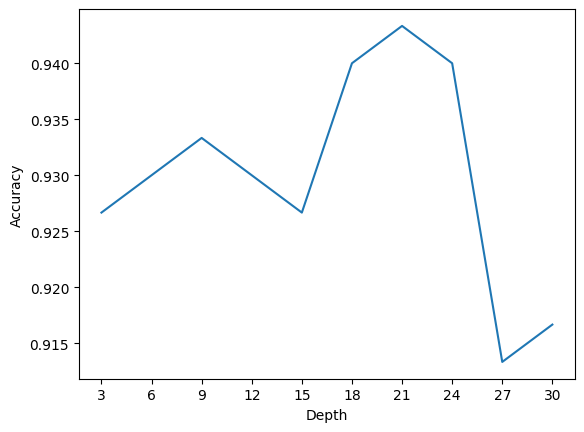

In [ ]:
depths = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
resulted_averages = []
retries = 10
for depth in depths:
  average_accuracy = 0
  for retry in range(retries):
    good_predictions = 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    for sample, gt in zip(x_test, y_test):
      prediction = dc.predict(sample)
      if prediction == gt:
        good_predictions += 1
    # print(f"Depth {depth}, retry {retry}, accuracy {good_predictions/len(x_test)/retries}")
    average_accuracy += good_predictions/len(x_test)/retries
  resulted_averages.append(average_accuracy)
plt.plot(depths, resulted_averages)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.show()


Dla głębokości zwiększających się co 3 od 3 do 30 średnie accuracy wydaje sie być nieco przypadkowe (powyżej jest przykładowy przebieg, ale często miał inną formę). Nie dziwi to bardzo dlatego, że jeżeli byśmy się przujżeli głębokościom uzyskiwanym dla zadanego random state to zauważyć można że głębokość nie wykracza poza 6 (nawet jeżeli zadamy bardzo dużą maksymalną wartość)

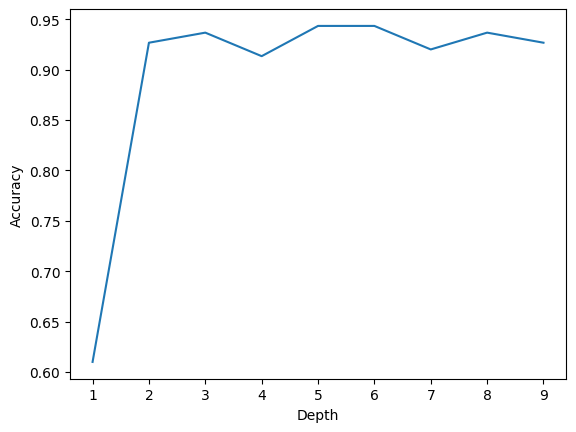

In [ ]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9]
resulted_averages = []
retries = 10
for depth in depths:
  average_accuracy = 0
  for retry in range(retries):
    good_predictions = 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    for sample, gt in zip(x_test, y_test):
      prediction = dc.predict(sample)
      if prediction == gt:
        good_predictions += 1
    # print(f"Depth {depth}, retry {retry}, accuracy {good_predictions/len(x_test)/retries}")
    average_accuracy += good_predictions/len(x_test)/retries
  resulted_averages.append(average_accuracy)
plt.plot(depths, resulted_averages)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.show()


Jeżeli przyjżymy się głęmbokościom od 1 do 9 to można zauważyć, że dla głębokości 1 średni błąd jest niski (ale nadal całkiem imonujący). Już nawet dl głębokości 2 dokładność skacze do około 0,925 i oscyluje w okolicach tej wartości dla każdej z pozostałych głębokości. Co ciekawe wraz ze wzrostem głembokości dokładność nie rośnie, a czasem nawet spada.

Podobna sytuacja powtarza się dla pozostałych podziałów dlatego nie będę opisywał dla każdego i dalsza analiza odbędzie się dla połączonych przebiegów.

#Podział 85 15

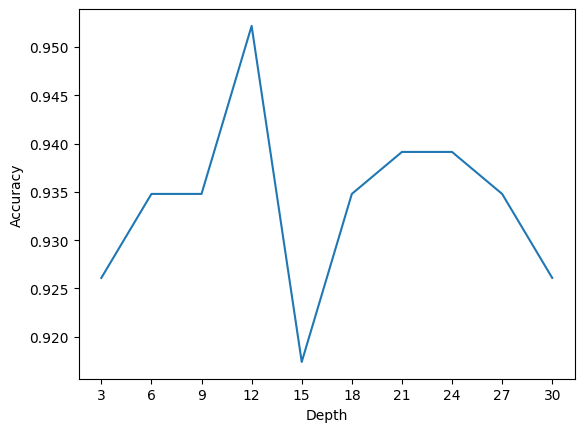

In [ ]:
depths = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
resulted_averages = []
retries = 10
for depth in depths:
  average_accuracy = 0
  for retry in range(retries):
    good_predictions = 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    for sample, gt in zip(x_test, y_test):
      prediction = dc.predict(sample)
      if prediction == gt:
        good_predictions += 1
    average_accuracy += good_predictions/len(x_test)/retries
  resulted_averages.append(average_accuracy)
plt.plot(depths, resulted_averages)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.show()

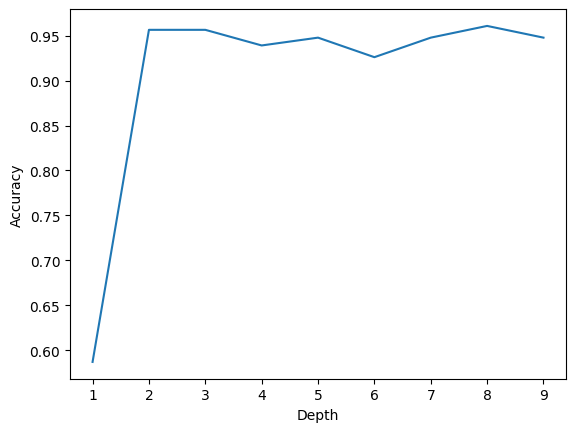

In [ ]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9]
resulted_averages = []
retries = 10
for depth in depths:
  average_accuracy = 0
  for retry in range(retries):
    good_predictions = 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    for sample, gt in zip(x_test, y_test):
      prediction = dc.predict(sample)
      if prediction == gt:
        good_predictions += 1
    average_accuracy += good_predictions/len(x_test)/retries
  resulted_averages.append(average_accuracy)
plt.plot(depths, resulted_averages)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.show()

#Podział 90 10

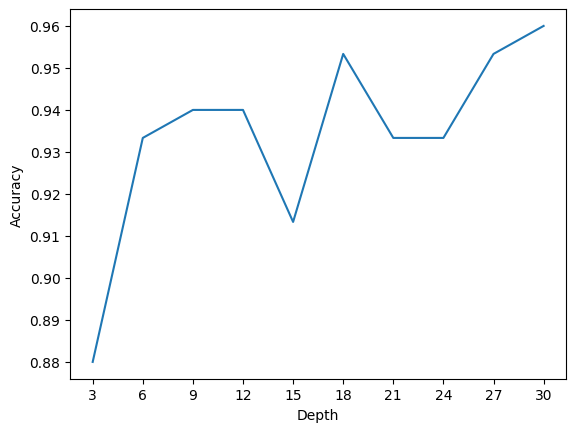

In [ ]:
depths = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
resulted_averages = []
retries = 10
for depth in depths:
  average_accuracy = 0
  for retry in range(retries):
    good_predictions = 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    for sample, gt in zip(x_test, y_test):
      prediction = dc.predict(sample)
      if prediction == gt:
        good_predictions += 1
    average_accuracy += good_predictions/len(x_test)/retries
  resulted_averages.append(average_accuracy)
plt.plot(depths, resulted_averages)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.show()

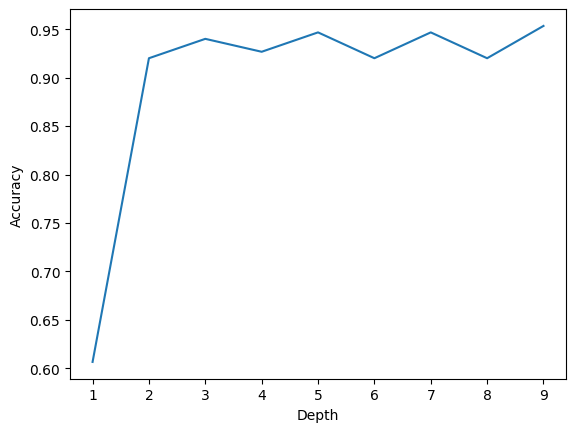

In [ ]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9]
resulted_averages = []
retries = 10
for depth in depths:
  average_accuracy = 0
  for retry in range(retries):
    good_predictions = 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    for sample, gt in zip(x_test, y_test):
      prediction = dc.predict(sample)
      if prediction == gt:
        good_predictions += 1
    average_accuracy += good_predictions/len(x_test)/retries
  resulted_averages.append(average_accuracy)
plt.plot(depths, resulted_averages)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.show()

#Podział 95 5

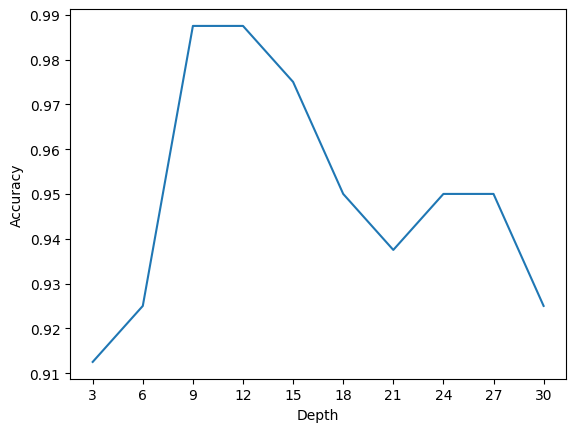

In [ ]:
depths = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
resulted_averages = []
retries = 10
for depth in depths:
  average_accuracy = 0
  for retry in range(retries):
    good_predictions = 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    for sample, gt in zip(x_test, y_test):
      prediction = dc.predict(sample)
      if prediction == gt:
        good_predictions += 1
    average_accuracy += good_predictions/len(x_test)/retries
  resulted_averages.append(average_accuracy)
plt.plot(depths, resulted_averages)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.show()

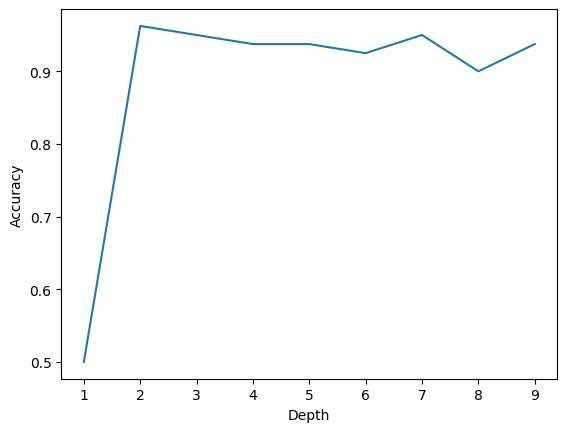

In [ ]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9]
resulted_averages = []
retries = 10
for depth in depths:
  average_accuracy = 0
  for retry in range(retries):
    good_predictions = 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    for sample, gt in zip(x_test, y_test):
      prediction = dc.predict(sample)
      if prediction == gt:
        good_predictions += 1
    average_accuracy += good_predictions/len(x_test)/retries
  resulted_averages.append(average_accuracy)
plt.plot(depths, resulted_averages)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.show()

#Porównanie na jednym wykresie

Dla pojedyńczych przebiegów accuracy trochę trudno wywnioskować cokolwiek dlatego poniżej widnieją połączone przebiegi dla powyższych rozkładów zbioru danych.

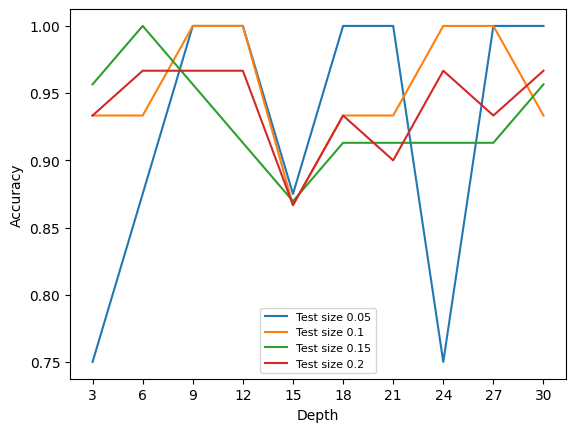

In [ ]:
depths = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_sizes = [0.05, 0.1, 0.15, 0.2]
resulted_averages = []
retries = 10
for test_size in test_sizes:
  average_accuracy = []
  for depth in depths:
    good_predictions = 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    for sample, gt in zip(x_test, y_test):
      prediction = dc.predict(sample)
      if prediction == gt:
        good_predictions += 1
    # print(f"Depth {depth}, retry {retry}, accuracy {good_predictions/len(x_test)}")
    average_accuracy.append(good_predictions/len(x_test))
  resulted_averages.append(average_accuracy)
for test_size in resulted_averages:
  plt.plot(depths, test_size)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.legend( [f'Test size {test_size}' for test_size in test_sizes], fontsize=8)
plt.show()

Dla dużych głębokości  dokładnośc bardzo oscyluje, ale można zauważyć, że dla mniejszych zbiorów testowych maksymalna dokładaność jest raczej większa, ale zarazem minima też są raczej niższe (i często częstsze). Te minima wynikają z zbytniego przetrenowania algorytmu w niektórych przypadkach.

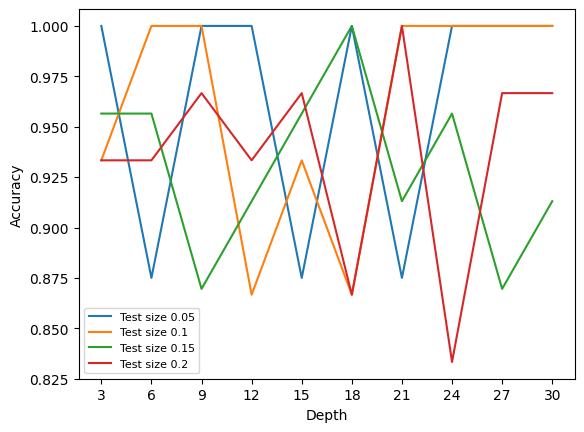

In [ ]:
depths = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
test_sizes = [0.05, 0.1, 0.15, 0.2]
resulted_averages = []
retries = 40
for test_size in test_sizes:
  average_accuracy = []
  for depth in depths:
    good_predictions = 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    for sample, gt in zip(x_test, y_test):
      prediction = dc.predict(sample)
      if prediction == gt:
        good_predictions += 1
    # print(f"Depth {depth}, retry {retry}, accuracy {good_predictions/len(x_test)/retries}")
    average_accuracy.append(good_predictions/len(x_test))
  resulted_averages.append(average_accuracy)
for test_size in resulted_averages:
  plt.plot(depths, test_size)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.legend( [f'Test size {test_size}' for test_size in test_sizes], fontsize=8)
plt.show()

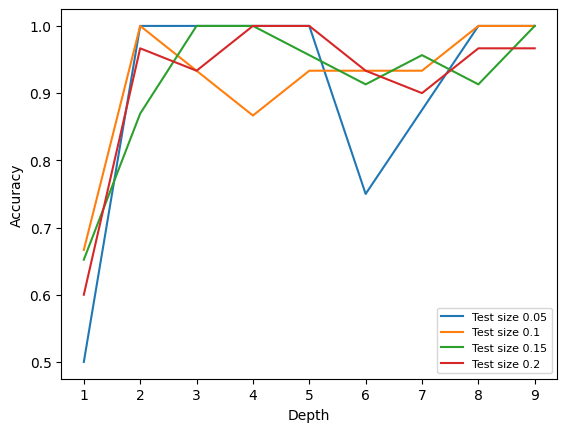

In [ ]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9]
test_sizes = [0.05, 0.1, 0.15, 0.2]
resulted_averages = []
retries = 10
for test_size in test_sizes:
  average_accuracy = []
  for depth in depths:
    good_predictions = 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    for sample, gt in zip(x_test, y_test):
      prediction = dc.predict(sample)
      if prediction == gt:
        good_predictions += 1
    # print(f"Depth {depth}, retry {retry}, accuracy {good_predictions/len(x_test)/retries}")
    average_accuracy.append(good_predictions/len(x_test))
  resulted_averages.append(average_accuracy)
for test_size in resulted_averages:
  plt.plot(depths, test_size)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.legend( [f'Test size {test_size}' for test_size in test_sizes], fontsize=8)
plt.show()

Najciekawszy jest wykres dla głębokości do 9. Dla wszystkich podziałów  dokładność utrzymuje się ponad 90%, ale dla podziałów 0,1 i 0,05 dokładność spada poniżej 90%. Wynika to jak w poprzedniej części z pretrenowania i faktu że w tych przypadkach trafiły się takie zbiory że przypadki graniczne trafiły do zbioru treningowego, a nie testowego.

Ciekawy jest również fakt, że w większości przypadków raczej dokładność jest wyższa dla mniejszych zbiorów testowych.

Według mnie najlepsze podziały są dla zbiorów testowych między 0,2 i 0,1, dają wtedy całkiem duże ilości danych do uczenia, a zarazem mamy spory zakres danych testowych co łatwiej pozwala ocenić otrzymane wyniki. Co prawda mniejszy zbiór treningowy powoduje, że średnia dokładność jest nieco niższa, ale zazwyczaj jest mniejsza szansa, że dokładność osiągnie bardzo niską wartość (bo jest mniejsza szansa, że jeden skrajny przypadek mocno wpłynie na wynik).

#Ten sam zbiór różne głębokości

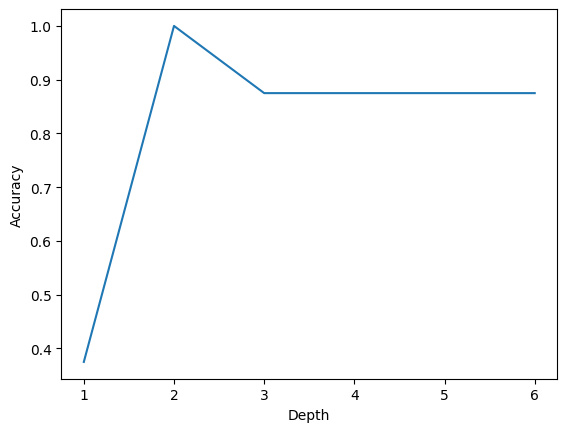

In [ ]:
depths = [1, 2, 3, 4, 5, 6]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05)
resulted_averages = []
retries = 10
for depth in depths:
  good_predictions = 0
  dc = DecisionTreeClassifier(depth)
  dc.build_tree(x_train, y_train)
  for sample, gt in zip(x_test, y_test):
    prediction = dc.predict(sample)
    if prediction == gt:
      good_predictions += 1
  resulted_averages.append(good_predictions/len(x_test))
plt.plot(depths, resulted_averages)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.show()

Dla niektórych przypadków wylosowanego podziału danych zachodzi sytuacja jak powyżej. Jeżeli byśmy przyjżeli się wynikom dla przykładu nałożonego z góry to zauważylibyśmy, że w pewnym momencie wraz ze wzrostem głębokości zmienia się osobnik dla którego źle zostaje przewidziana klasa. Wynika to z tego, że taki osobnik jest graniczny i przy małych głębokościach "trafia" do węzła gdzie klasa jest wyznaczana przez większość klas w danej grupie. Ale ze wzrostem głębokości powstają nowe podziały i przez to że taki osobnik jest graniczny, trafia do złego przedziału, bo żaden inny osobnik nie może go objąć "swoim zakresem".

#Skrajne Podziały


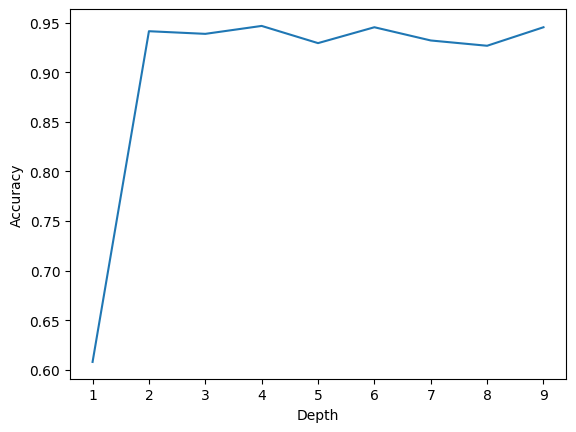

In [6]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9]
resulted_averages = []
retries = 10
for depth in depths:
  average_accuracy = 0
  for retry in range(retries):
    good_predictions = 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    for sample, gt in zip(x_test, y_test):
      prediction = dc.predict(sample)
      if prediction == gt:
        good_predictions += 1
    average_accuracy += good_predictions/len(x_test)/retries
  resulted_averages.append(average_accuracy)
plt.plot(depths, resulted_averages)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.show()

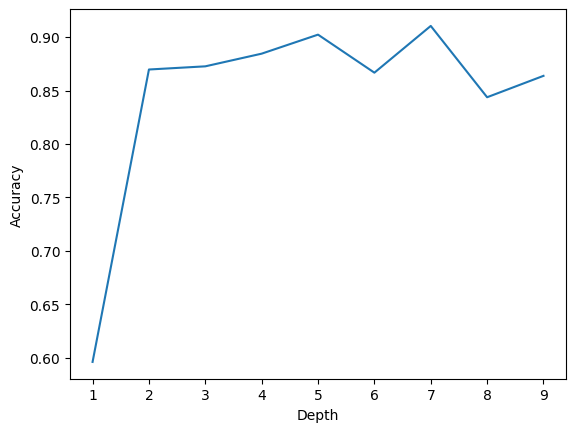

In [5]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9]
resulted_averages = []
retries = 10
for depth in depths:
  average_accuracy = 0
  for retry in range(retries):
    good_predictions = 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    for sample, gt in zip(x_test, y_test):
      prediction = dc.predict(sample)
      if prediction == gt:
        good_predictions += 1
    average_accuracy += good_predictions/len(x_test)/retries
  resulted_averages.append(average_accuracy)
plt.plot(depths, resulted_averages)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.show()

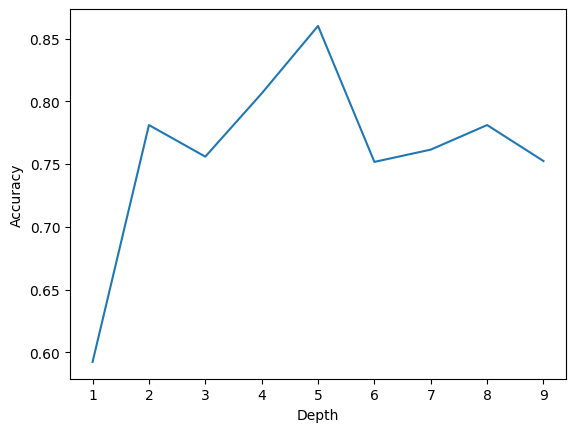

In [4]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9]
resulted_averages = []
retries = 10
for depth in depths:
  average_accuracy = 0
  for retry in range(retries):
    good_predictions = 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.95)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    for sample, gt in zip(x_test, y_test):
      prediction = dc.predict(sample)
      if prediction == gt:
        good_predictions += 1
    average_accuracy += good_predictions/len(x_test)/retries
  resulted_averages.append(average_accuracy)
plt.plot(depths, resulted_averages)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.show()

Dla skrajnych podziałów dokładność jest zazwyczaj mniejsza niż dla podziałów badanych wcześniej wynika to z faut, że algorytm ma za mało danych aby dobrze się "nauczyć". Ale te spadki są stosunkowo nieduże.

#Stały random state

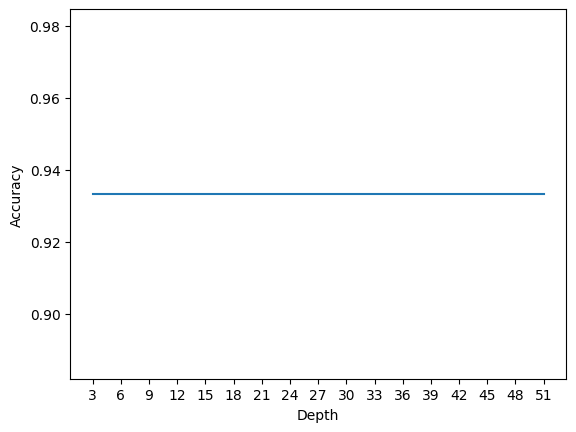

In [ ]:
depths = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51]
resulted_averages = []
retries = 1
for depth in depths:
  average_accuracy = 0
  for retry in range(retries):
    good_predictions = 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    for sample, gt in zip(x_test, y_test):
      prediction = dc.predict(sample)
      if prediction == gt:
        good_predictions += 1
    average_accuracy += good_predictions/len(x_test)/retries
  resulted_averages.append(average_accuracy)
plt.plot(depths, resulted_averages)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=depths)
plt.show()